In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
import time
import matplotlib.pyplot as pl
import numpy as np
import itertools as it
from astropy.io import fits
import healpy as hp
from scipy import linalg

from src import core as cr
from src import this_project as P

In [3]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
LMAX = NSIDE
BEAMSIZE = 0.5

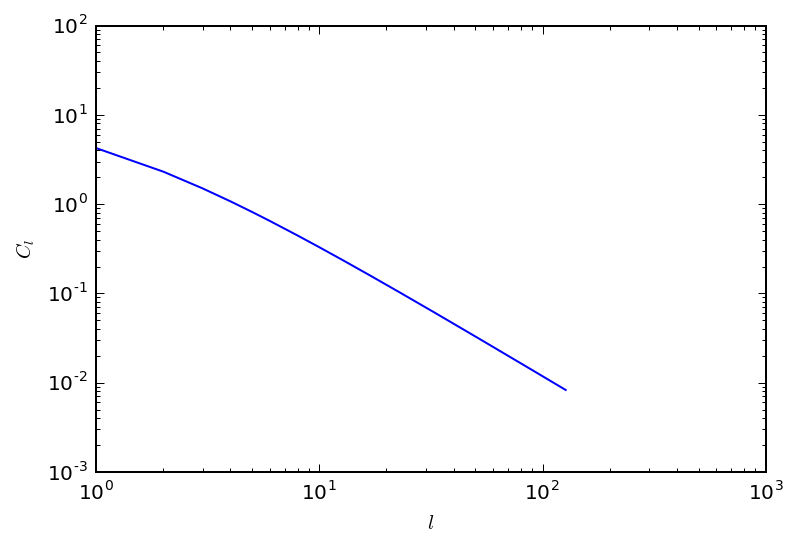

In [4]:
power = (lambda k: 12 / (k + 1) ** 1.5)
cl_in = power(np.arange(LMAX))
ls = np.arange(cl_in.size)
pl.loglog(cl_in)
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


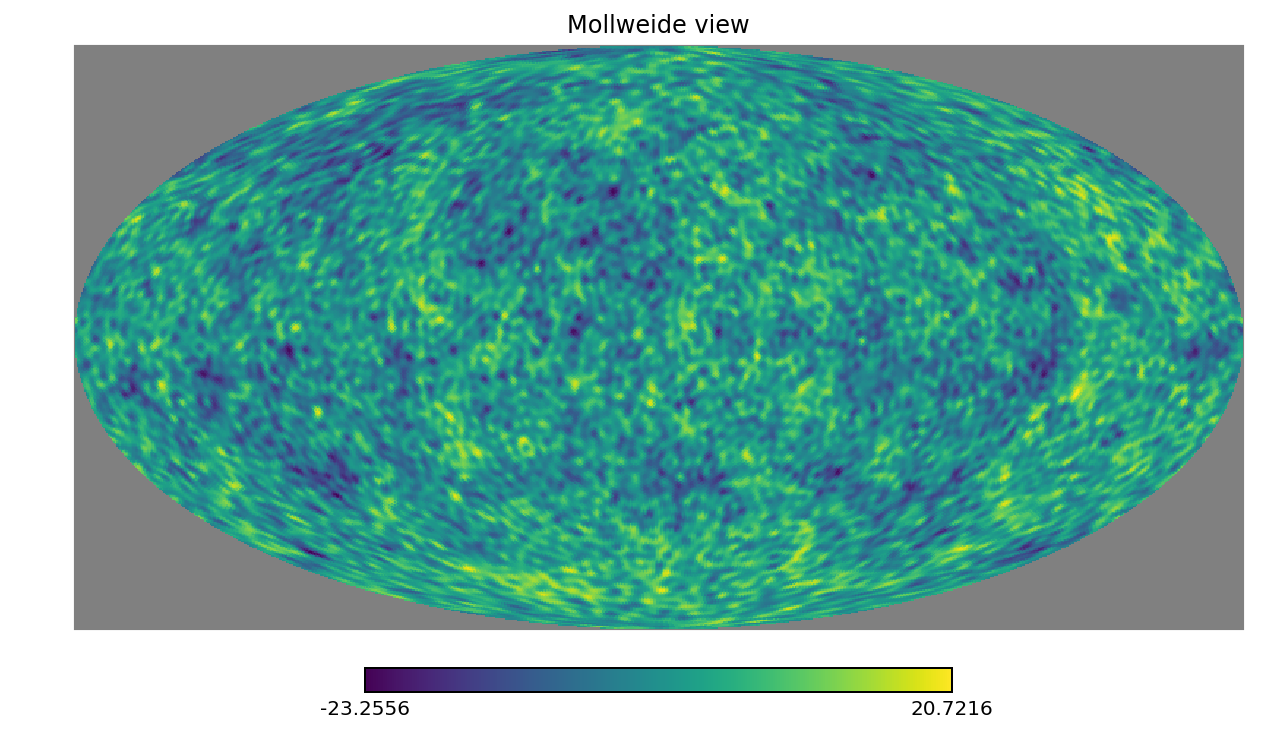

In [5]:
# generate field
random_field = hp.synfast(cl_in, NSIDE, verbose=False)

# simulate beam
random_field = hp.smoothing(random_field, fwhm=np.deg2rad(BEAMSIZE), iter=1)

# view field
hp.mollview(random_field, cmap=P.CMAP)

In [6]:
full_mask = fits.getdata('/Users/dlenz/projects/planck/mask_galplane_2048.hpx.fits')
mask = hp.ud_grade(full_mask['GAL060'].astype(np.float32), NSIDE, order_in='nest', order_out='ring')
mask = hp.smoothing(mask, fwhm=np.deg2rad(1.), iter=1, verbose=False)

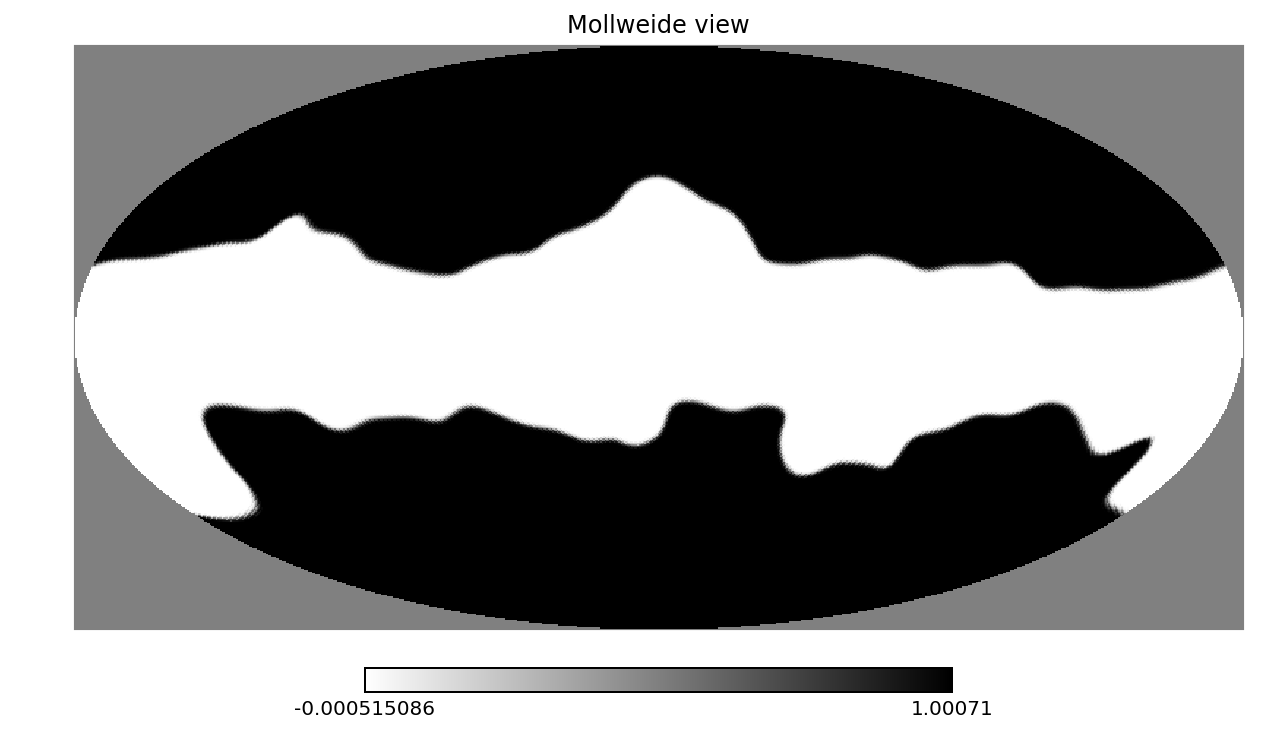

In [7]:
hp.mollview(mask, cmap=P.CMAP_GREY)

In [8]:
cl_mask = hp.anafast(mask, lmax=LMAX-1)

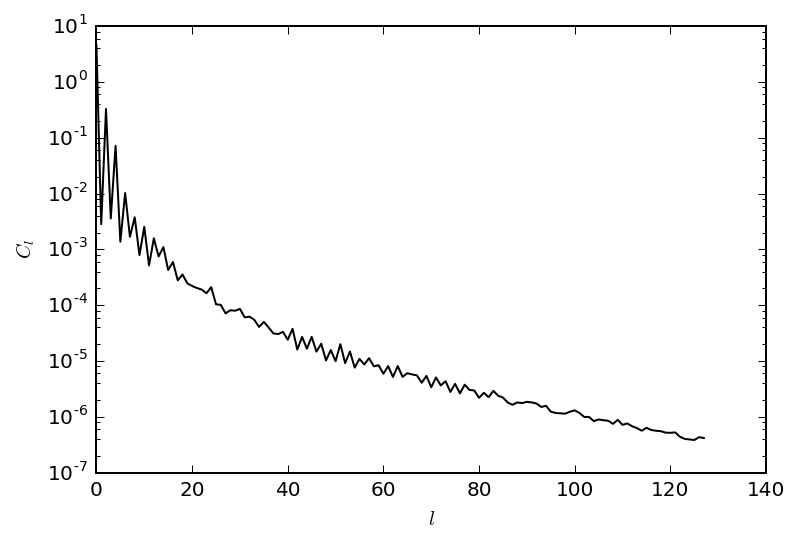

In [9]:
pl.plot(cl_mask, c='k')
pl.yscale('log')
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

In [10]:
pixfunc = hp.pixwin(NSIDE)[:LMAX]
beamfunc = hp.gauss_beam(np.deg2rad(BEAMSIZE), LMAX-1)
windowfunc = pixfunc * beamfunc

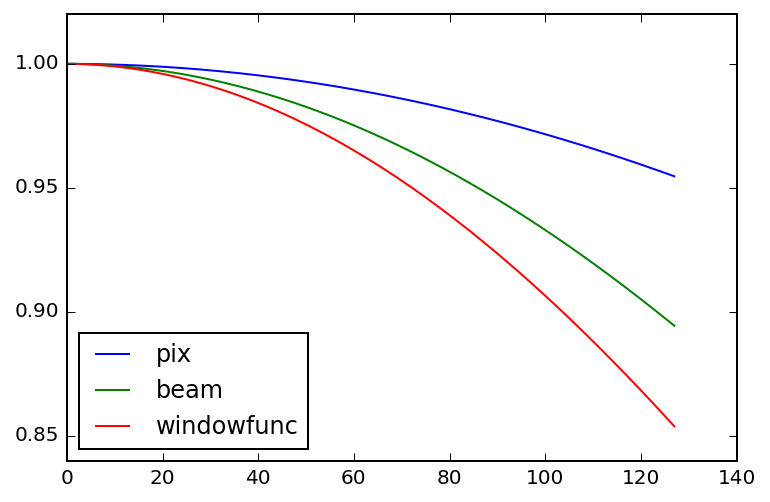

In [11]:
pl.plot(pixfunc, label='pix')
pl.plot(beamfunc, label='beam')
pl.plot(windowfunc, label='windowfunc')
pl.legend(loc='lower left')

In [12]:
cl_conv = hp.sphtfunc.anafast(random_field*mask, lmax=LMAX-1)

In [13]:
M = cr.make_M_l1l2(ls, W=cl_mask)

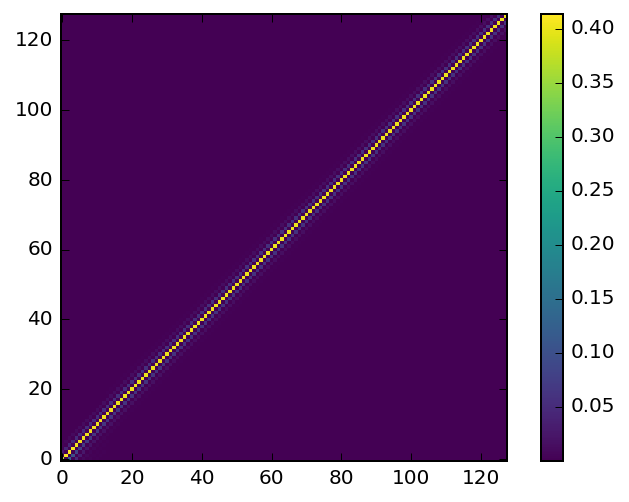

In [14]:
pl.imshow(M, interpolation='None', origin='lower', cmap=P.CMAP)
pl.colorbar()

In [15]:
M_inv = linalg.inv(M)

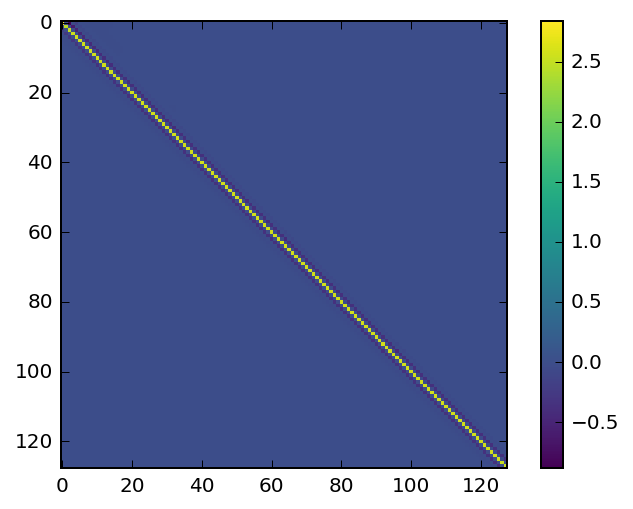

In [16]:
pl.imshow(M_inv, interpolation='None', cmap=P.CMAP)
pl.colorbar()

In [17]:
P_bl, bin_centres = cr.make_P_bl(ls, 25)
Q_lb, _ = cr.make_Q_lb(ls, 25)

In [18]:
cl_bin = np.dot(P_bl, cl_conv)

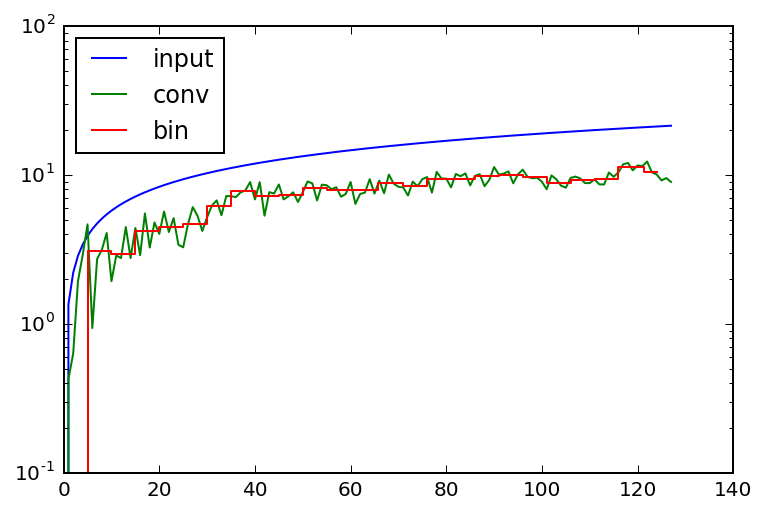

In [19]:
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_in, label='input')
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_conv, label='conv')
pl.plot(bin_centres, cl_bin, label='bin', drawstyle='steps-mid')
pl.legend(loc='best')
pl.yscale('log')

In [20]:
cl_deconv, bin_centres = cr.get_C_b(ls, cl_conv, nbins=25, W=cl_mask, B=windowfunc)

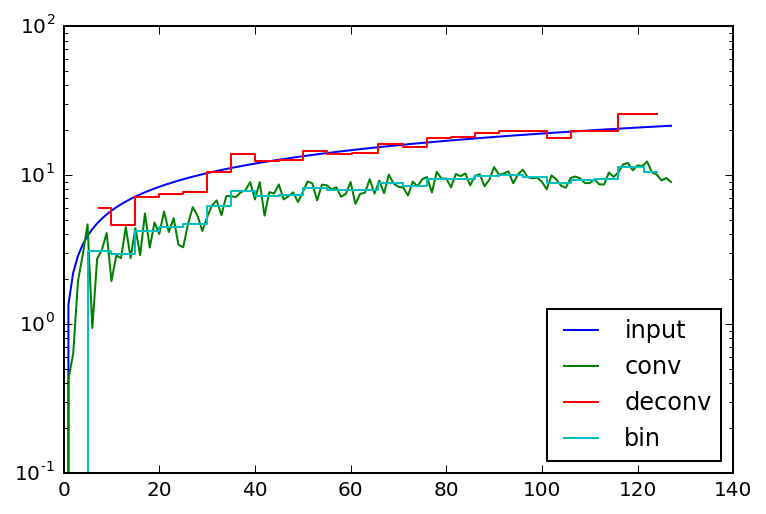

In [21]:
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_in, label='input')
pl.plot(ls, ls * (ls+1)/2./np.pi * cl_conv, label='conv')
pl.plot(bin_centres[1:], cl_deconv, label='deconv', drawstyle='steps-mid')
pl.plot(bin_centres, cl_bin, label='bin', drawstyle='steps-mid')
pl.legend(loc='best')
pl.yscale('log')